Připojení k databázi bylo úspěšné

HTML report byl úspěšně vygenerován.

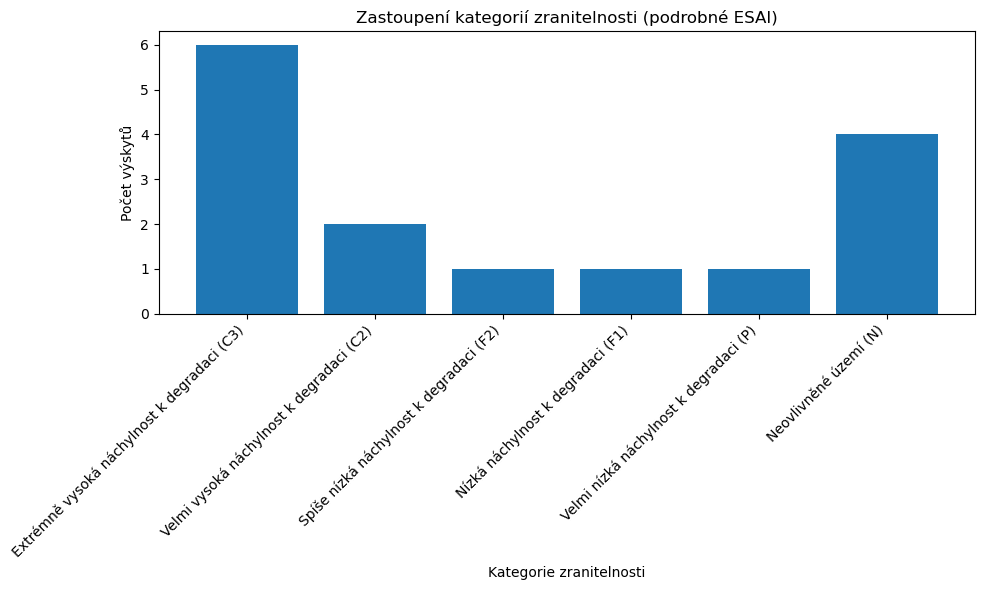

In [10]:
from datetime import datetime
import uuid
import psycopg2
from rich import print
import matplotlib.pyplot as plt
import io
import base64

rozsahy_kategorii = {
    "N": (1.00, 1.17, "Neovlivněné území", "#1a9850"),
    "P": (1.17, 1.22, "Velmi nízká náchylnost k degradaci", "#66bd63"),
    "F1": (1.22, 1.26, "Nízká náchylnost k degradaci", "#a6d96a"),
    "F2": (1.26, 1.32, "Spíše nízká náchylnost k degradaci", "#d9ef8b"),
    "F3": (1.32, 1.37, "Střední náchylnost k degradaci", "#fee08b"),
    "C1": (1.37, 1.41, "Vysoká náchylnost k degradaci", "#fdae61"),
    "C2": (1.41, 1.53, "Velmi vysoká náchylnost k degradaci", "#f46d43"),
    "C3": (1.53, 2.00, "Extrémně vysoká náchylnost k degradaci", "#d73027"),
    "N/A": (None, None, "N/A", "#000000")  # Pro 0 vody
}

def urci_kategorii(vazeny_prumer):
    if vazeny_prumer is None:
        return "N/A", "N/A"

    for kod, (minimum, maximum, nazev, _) in rozsahy_kategorii.items():
        if minimum is not None and maximum is not None:
            if minimum <= vazeny_prumer <= maximum:
                return f"{nazev} ({kod})", kod
        elif kod == "N/A" and vazeny_prumer is None:
            return "N/A", "N/A"

    return "Neznámá kategorie", None

def urci_barvu_klasicke_meritko(meritko):
    meritko_cislo = int(meritko.replace("1:", "").replace(" ", ""))
    if meritko_cislo <= 10000:
        return "#006400", ""
    elif meritko_cislo <= 50000:
        return "#FFA500", "Měřítko má méně přesné rozlišení."
    else:
        return "#FF0000", "Měřítko velmi hrubé - Data je potřeba interpretovat obezřetně."

def urci_barvu_meritko_na_pixel(meritko):
    meritko_cislo = int(meritko.replace("m/px", "").replace(" ", ""))
    if meritko_cislo <= 20:
        return "#006400", ""
    elif meritko_cislo <= 100:
        return "#FFA500", "Měřítko má méně přesné rozlišení."
    else:
        return "#FF0000", "Měřítko velmi hrubé - Data je potřeba interpretovat obezřetně."

def urci_barvu_rok(rok):
    aktualni_rok = datetime.now().year
    rozdil = aktualni_rok - rok
    if rozdil < 3:
        return "#1a9641"
    elif rozdil < 5:
        return "#fdae61"
    else:
        return "#d7191c"

dbname = 'DP_pokus'
user = 'postgres'
password = 'kapli4ky'
host = 'localhost'
port = '5432'

try:
    connection = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
    cursor = connection.cursor()
    print("Připojení k databázi bylo úspěšné")

    sql_query_verohodnost_esai = "SELECT zkratka_txt, datovy_zdroj, indikator_cz, meritko, last_update, source_dat FROM metadata_dat"
    sql_query_funkce = "SELECT AVG(hb_n) AS hodnota_hb, AVG(ctot_n) AS hodnota_uhlik, AVG(evap_n) AS hodnota_evapotranspirace FROM cernovice_esai_na_ctverec;"
    sql_query_esai_hlavni = """
        SELECT AVG(w_veget) AS "Stav vegetace", AVG(w_clim) AS "Stav klimatu", AVG(w_soil) AS "Stav půdy", AVG(w_mgm) AS "Intenzita lidské činnosti" FROM cernovice_esai_na_ctverec;
        """

    sql_query_esai_podrobne = """
        SELECT AVG(dra_w) AS "Propustnost", AVG(par_w) AS "Matečná hornina", AVG(dep_w) AS "Hloubka půdy", AVG(fra_w) AS "Skeletovitost", AVG(tex_w) AS "Textura", AVG(slo_w) AS "Sklonitost svahu", AVG(den_w) AS "Hustota populace", AVG(grw_w) AS "Populační růst", AVG(int_w) AS "Intenzita využití půdy", AVG(w_rai) AS "Průměrný roční úhrn srážek", AVG(arid_w) AS "Index sucha", AVG(asp_w) AS "Orientace svahu", AVG(dry_w) AS "Odolnost vegetace vůči suchu", AVG(ero_w) AS "Schopnost vegetace bránit erozi", AVG(pla_w) AS "Pokryvnost vegetace" FROM cernovice_esai_na_ctverec;
        """

    sql_query_esai = """
        SELECT AVG(w_esai) AS "Zranitelnost krajiny" FROM cernovice_esai_na_ctverec;
        """

    cursor.execute(sql_query_verohodnost_esai)
    data_verohodnost_esai = cursor.fetchall()

    cursor.execute(sql_query_funkce)
    data_funkce = cursor.fetchall()[0] if cursor.rowcount > 0 else None

    cursor.execute(sql_query_esai)
    data_esai = cursor.fetchall()[0][0] if cursor.rowcount > 0 else None

    cursor.execute(sql_query_esai_hlavni)
    data_esai_hlavni = cursor.fetchall()[0] if cursor.rowcount > 0 else None

    cursor.execute(sql_query_esai_podrobne)
    data_esai_podrobne = cursor.fetchall()[0] if cursor.rowcount > 0 else None

    hlavni_esai_kategorie = sorted(
        [("Stav vegetace", data_esai_hlavni[0]), ("Stav klimatu", data_esai_hlavni[1]), ("Stav půdy", data_esai_hlavni[2]), ("Intenzita lidské činnosti", data_esai_hlavni[3])],
        key=lambda x: x[1], reverse=True
    )

    podrobne_esai = sorted(
        [("Propustnost", data_esai_podrobne[0]), ("Matečná hornina", data_esai_podrobne[1]), ("Hloubka půdy", data_esai_podrobne[2]), ("Skeletovitost", data_esai_podrobne[3]), ("Textura", data_esai_podrobne[4]), ("Sklonitost svahu", data_esai_podrobne[5]), ("Hustota populace", data_esai_podrobne[6]), ("Populační růst", data_esai_podrobne[7]), ("Intenzita využití půdy", data_esai_podrobne[8]), ("Průměrný roční úhrn srážek", data_esai_podrobne[9]), ("Index sucha", data_esai_podrobne[10]), ("Orientace svahu", data_esai_podrobne[11]), ("Odolnost vegetace vůči suchu", data_esai_podrobne[12]), ("Schopnost vegetace bránit erozi", data_esai_podrobne[13]), ("Pokryvnost vegetace", data_esai_podrobne[14])],
        key=lambda x: x[1], reverse=True
    )

    if data_funkce:
        hodnota_hb, hodnota_uhlik, hodnota_evapotranspirace = data_funkce
    else:
        hodnota_uhlik = "---"
        hodnota_evapotranspirace = "---"
        hodnota_hb = "---"

    def generuj_tabulku_hlavni_kategorie(hlavni_esai_kategorie, urci_kategorii, rozsahy_kategorii):
        tabulka_html = "<table><tr><th>Téma</th><th>Hodnota</th><th>Kategorie</th></tr>"
        for tema, hodnota in hlavni_esai_kategorie:
            kategorie, kod_kategorie = urci_kategorii(hodnota)
            barva_textu = rozsahy_kategorii[kod_kategorie][3] if kod_kategorie in rozsahy_kategorii else "#000000"
            tabulka_html += f"<tr><td><strong>{tema}</strong></td><td>{hodnota}</td><td style='color: {barva_textu};'>{kategorie}</td></tr>"
        tabulka_html += "</table>"
        return tabulka_html

    def generuj_tabulku_podrobna_temata(podrobne_esai, urci_kategorii, rozsahy_kategorii):
        tabulka_html = "<table><tr><th>Téma</th><th>Hodnota</th><th>Kategorie</th></tr>"
        for tema, hodnota in podrobne_esai:
            kategorie, kod_kategorie = urci_kategorii(hodnota)
            barva_textu = rozsahy_kategorii[kod_kategorie][3] if kod_kategorie in rozsahy_kategorii else "#000000"
            tabulka_html += f"<tr><td>{tema}</td><td>{hodnota}</td><td style='color: {barva_textu};'>{kategorie}</td></tr>"
        tabulka_html += "</table>"
        return tabulka_html

    tabulka_hlavni = generuj_tabulku_hlavni_kategorie(hlavni_esai_kategorie, urci_kategorii, rozsahy_kategorii)
    tabulka_podrobna = generuj_tabulku_podrobna_temata(podrobne_esai, urci_kategorii, rozsahy_kategorii)

    timestamp = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    id = uuid.uuid1()

    kategorie_esai, kod_kategorie_esai = urci_kategorii(data_esai)

    # Sbírání dat pro graf (pouze z podrobne_esai)
    kategorie_counts = {}
    for tema, hodnota in podrobne_esai:
        kategorie, _ = urci_kategorii(hodnota)
        kategorie_counts[kategorie] = kategorie_counts.get(kategorie, 0) + 1

    # Sbírání dat pro graf (pouze z podrobne_esai)
    kategorie_counts = {}
    for tema, hodnota in podrobne_esai:
        kategorie, _ = urci_kategorii(hodnota)
        kategorie_counts[kategorie] = kategorie_counts.get(kategorie, 0) + 1

    # Generování grafu
    kategorie_names = list(kategorie_counts.keys())
    counts = list(kategorie_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(kategorie_names, counts)
    plt.xlabel("Kategorie zranitelnosti")
    plt.ylabel("Počet výskytů")
    plt.title("Zastoupení kategorií zranitelnosti (podrobné ESAI)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Uložení grafu do paměti
    buf = io.BytesIO()
    plt.savefig(buf, format="png")  # Uloží graf jako PNG do paměti
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode()  # Zakóduje graf do base64
    buf.close()

    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Zranitelnost krajiny</title>
        <meta charset='UTF-8'>
        <meta name='description' content='HTML stránka georeportu zranitelnosti krajiny'>
        <meta name='keywords' content='zranitelnost krajiny, georeport, ekologie'>
        <meta name='author' content='Adéla Petřeková'>
        <style>
            @page {{
                size: A4;
                margin: 10mm 20mm;
                @bottom-center {{
                    content: "Strana " counter(page);
                    font-family: Arial, sans-serif;
                    text-align: center;
                }}
            }}
            body {{
                font-family: Arial, sans-serif;
                margin: 0;
                padding: 0;
            }}
            h1 {{
                background-color: #4CAF50;
                color: #fff;
                padding: 10px;
            }}
            p {{
                padding: 10px;
            }}
            .footer {{
                position: fixed;
                bottom: 0;
                width: 100%;
                text-align: center;
            }}
            .footer hr {{
                width: 100%;
                border: none;
                border-top: 1px solid #000;
                margin: 0;
            }}
            .footer-content {{
                display: flex;
                justify-content: space-between;
                align-items: center;
                padding: 0 0;
            }}
            .footer img {{
                height: 50px;
            }}
            .page_number {{
                font-family: Arial, sans-serif;
            }}
            .indicator-box {{
                border: 2px solid #4CAF50;
                padding: 10px;
                margin: 10px 0;
            }}
            table {{
                width: 100%;
                border-collapse: collapse;
            }}
            th, td {{
                border: 1px solid #000;
                padding: 8px;
                text-align: left;
            }}
            th {{
                background-color: #f2f2f2;
            }}
            .graf-container {{
                max-width: 100%;
                overflow-x: auto; /* Přidá horizontální posuvník, pokud je graf příliš široký */
            }}
            .graf-container img {{
                max-width: 100%;
                height: auto;
            }}
        </style>
    </head>
    <body>
        <header>
            <h1>Název reportu: Zranitelnost krajiny</h1>
            <p>Lokalita: XXX (GPS souřadnice) <br>
            Souřadnice: MBR extentu <br>
            Datum a čas generování: {timestamp} <br>
            Unikatní identifikátor: {id}
            </p>
        </header>
        <main>
            <p> Tento report podává zprávu o degradaci krajiny na základě metody ESAI ....</p>

            <h2> Krok I: Náchylnost krajiny k degradaci </h2>
            <p> Ve zvoleném území dosahuje výsledná hodnota náchylnosti k degradaci hodnoty <strong>{data_esai}</strong> a je klasifikována jako <span style="color: {rozsahy_kategorii[kod_kategorie_esai][3]};">{kategorie_esai}</span>.</p>
            {tabulka_hlavni}

            <h3> Podřazená témata </h3>
            {tabulka_podrobna}

    """

    serazene_podrobne_esai = sorted(podrobne_esai, key=lambda x: x[1], reverse=True)
    nejhorsi_indikatory = [f"<em>{tema}</em>" for tema, _ in serazene_podrobne_esai[:3]]
    html += "<div class='indicator-box'> Nejhorší 3 indikátory v zájmovém území jsou: " + ", ".join(nejhorsi_indikatory) + ".</div>"

    html += f"""
            <div class="graf-container">
            <h4>Graf: Zastoupení kategorií zranitelnosti (podrobné ESAI)</h4>
            <img src="data:image/png;base64,{image_base64}" alt="Graf zastoupení kategorií (podrobné ESAI)">
            </div>
            <h3> Věrohodnost dat </h3>
            <table>
                <tr>
                    <th> Zkratka </th>
                    <th> Název </th>
                    <th> Datový zdroj </th>
                    <th> Garant </th>
                    <th> Měřítko </th>
                    <th> Rok aktualizace </th>
                </tr>
    """

    for zkratka_txt, datovy_zdroj, indikator_cz, meritko, last_update, source_dat in data_verohodnost_esai:
        if "1:" in meritko:
            barva, poznamka = urci_barvu_klasicke_meritko(meritko)
        elif "m/px" in meritko:
            barva, poznamka = urci_barvu_meritko_na_pixel(meritko)
        barva_rok = urci_barvu_rok(last_update)

        html += f"""
                <tr>
                    <td> {zkratka_txt} </td>
                    <td> {indikator_cz} </td>
                    <td> {datovy_zdroj} </td>
                    <td> {source_dat} </td>
                    <td style="color: {barva};"> {meritko} {poznamka} </td>
                    <td style="color: {barva_rok};"> {last_update} </td>
                </tr>
        """

    html += f"""
            </table>
            <h2> Krok II: Posouzení funkčnosti krajiny </h2>
            <p> slouží k nalezení krajinných segmentů jejichž degradace bude mít velký/malý význam dopad na funkčnost krajiny </p>
            <table>
                <tr>
                    <th> </th>
                    <th> Hodnota </th>
                    <th> Kategorie </th>
                </tr>
                <tr>
                    <td> Zásoba uhlíku ve vegetaci </td>
                    <td> {hodnota_uhlik} </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Evapotranspirace </td>
                    <td> {hodnota_evapotranspirace} </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Ekologická hodnota biotopu </td>
                    <td> {hodnota_hb} </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Vodoretence </td>
                    <td> Hodnota 1 </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Integrovaná hodnota </td>
                    <td> --- </td>
                    <td> Kategorie 1 </td>
                </tr>
            </table>
            <h3> Věrohodnost dat </h3>
            <table>
                <tr>
                    <th> Název </th>
                    <th> Datový zdroj geometrie/KB </th>
                    <th> Garant </th>
                    <th> Měřítko </th>
                    <th> Rok aktualizace </th>
                </tr>
                <tr>
                    <td> Indikátor 1 </td>
                    <td> Hodnota 1 </td>
                    <td> Věrohodnost 1 </td>
                    <td> meritko </td>
                    <td> ROK </td>
                </tr>
            </table>
            <h2> Krok III: Odolnost krajiny </h2>
            <h2> Krok IV: Syntéza/lokalizace prioritních opatření </h2>
            <h2> Krok V: Typizace prioritních opatření </h2>
        </main>
        <footer>
            <div class="footer">
                <hr>
                <div class="footer-content">
                    <img src="katedra_logo.png" alt="Logo KGI">
                    <img src="logo_czechglobe.png" alt="Logo CzechGlobe">
                </div>
            </div>
        </footer>
    </body>
    </html>
    """

    with open("report.html", "w", encoding="utf-8") as file:
        file.write(html)

    print("HTML report byl úspěšně vygenerován.")

except Exception as error:
    print(f"Chyba při připojování k databázi: {error}")

finally:
    if connection:
        cursor.close()
        connection.close()

In [11]:
# Vytvoření HTML souboru
with open("index.html", "w", encoding="utf-8") as f:
    f.write(html)

print("HTML report byl úspěšně vygenerován.")

# (Pokud chcete otevřít soubor v prohlížeči, odkomentujte následující řádky)
# import webbrowser
# webbrowser.open("index.html")

HTML report byl úspěšně vygenerován.

In [13]:
# output html as a PDF
# first, import the necessary modules

from weasyprint import HTML
# then, convert the HTML to a PDF
HTML("index.html").write_pdf("index.pdf")

print("Generated index.pdf")
#otevření pdf souboru
import webbrowser
webbrowser.open("index.pdf")

Generated index.pdf

True

In [20]:
import sys
import json
import tempfile
from weasyprint import HTML
from datetime import datetime
import uuid
import psycopg2
from rich import print
import matplotlib.pyplot as plt
import io
import base64
import geopandas as gpd
import contextily as ctx

rozsahy_kategorii = {
    "N": (1.00, 1.17, "Neovlivněné území", "#1a9850"),
    "P": (1.17, 1.22, "Velmi nízká náchylnost k degradaci", "#66bd63"),
    "F1": (1.22, 1.26, "Nízká náchylnost k degradaci", "#a6d96a"),
    "F2": (1.26, 1.32, "Spíše nízká náchylnost k degradaci", "#d9ef8b"),
    "F3": (1.32, 1.37, "Střední náchylnost k degradaci", "#fee08b"),
    "C1": (1.37, 1.41, "Vysoká náchylnost k degradaci", "#fdae61"),
    "C2": (1.41, 1.53, "Velmi vysoká náchylnost k degradaci", "#f46d43"),
    "C3": (1.53, 2.00, "Extrémně vysoká náchylnost k degradaci", "#d73027"),
    "N/A": (None, None, "N/A", "#000000")  # Pro 0 vody
}

def urci_kategorii(vazeny_prumer):
    if vazeny_prumer is None:
        return "N/A", "N/A"

    for kod, (minimum, maximum, nazev, _) in rozsahy_kategorii.items():
        if minimum is not None and maximum is not None:
            if minimum <= vazeny_prumer <= maximum:
                return f"{nazev} ({kod})", kod
        elif kod == "N/A" and vazeny_prumer is None:
            return "N/A", "N/A"

    return "Neznámá kategorie", None

def urci_barvu_klasicke_meritko(meritko):
    meritko_cislo = int(meritko.replace("1:", "").replace(" ", ""))
    if meritko_cislo <= 10000:
        return "#006400", ""
    elif meritko_cislo <= 50000:
        return "#FFA500", "Měřítko má méně přesné rozlišení."
    else:
        return "#FF0000", "Měřítko velmi hrubé - Data je potřeba interpretovat obezřetně."

def urci_barvu_meritko_na_pixel(meritko):
    meritko_cislo = int(meritko.replace("m/px", "").replace(" ", ""))
    if meritko_cislo <= 20:
        return "#006400", ""
    elif meritko_cislo <= 100:
        return "#FFA500", "Měřítko má méně přesné rozlišení."
    else:
        return "#FF0000", "Měřítko velmi hrubé - Data je potřeba interpretovat obezřetně."

def urci_barvu_rok(rok):
    aktualni_rok = datetime.now().year
    rozdil = aktualni_rok - rok
    if rozdil < 3:
        return "#1a9641"
    elif rozdil < 5:
        return "#fdae61"
    else:
        return "#d7191c"

def generuj_mapu_esai(gdf, rozsahy_kategorii):
    fig, ax = plt.subplots(figsize=(10, 8))

    for kategorie, data in gdf.groupby('kategorie'):
        barva = rozsahy_kategorii[kategorie][3]  # Získání barvy z rozsahy_kategorii
        data.plot(ax=ax, color=barva, edgecolor='black', label=kategorie)

    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    ax.legend(title="Kategorie ESAI")

    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode()
    buf.close()

    return image_base64

dbname = 'DP_pokus'
user = 'postgres'
password = 'kapli4ky'
host = 'localhost'
port = '5432'

try:
    connection = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
    cursor = connection.cursor()
    print("Připojení k databázi bylo úspěšné")

    sql_query_verohodnost_esai = "SELECT zkratka_txt, datovy_zdroj, indikator_cz, meritko, last_update, source_dat FROM metadata_dat"
    sql_query_funkce = "SELECT AVG(hb_n) AS hodnota_hb, AVG(ctot_n) AS hodnota_uhlik, AVG(evap_n) AS hodnota_evapotranspirace FROM cernovice_esai_na_ctverec;"
    sql_query_esai_hlavni = """
        SELECT AVG(w_veget) AS "Stav vegetace", AVG(w_clim) AS "Stav klimatu", AVG(w_soil) AS "Stav půdy", AVG(w_mgm) AS "Intenzita lidské činnosti" FROM cernovice_esai_na_ctverec;
        """

    sql_query_esai_podrobne = """
        SELECT AVG(dra_w) AS "Propustnost", AVG(par_w) AS "Matečná hornina", AVG(dep_w) AS "Hloubka půdy", AVG(fra_w) AS "Skeletovitost", AVG(tex_w) AS "Textura", AVG(slo_w) AS "Sklonitost svahu", AVG(den_w) AS "Hustota populace", AVG(grw_w) AS "Populační růst", AVG(int_w) AS "Intenzita využití půdy", AVG(w_rai) AS "Průměrný roční úhrn srážek", AVG(arid_w) AS "Index sucha", AVG(asp_w) AS "Orientace svahu", AVG(dry_w) AS "Odolnost vegetace vůči suchu", AVG(ero_w) AS "Schopnost vegetace bránit erozi", AVG(pla_w) AS "Pokryvnost vegetace" FROM cernovice_esai_na_ctverec;
        """

    sql_query_esai = """
        SELECT AVG(w_esai) AS "Zranitelnost krajiny" FROM cernovice_esai_na_ctverec;
        """

    cursor.execute(sql_query_verohodnost_esai)
    data_verohodnost_esai = cursor.fetchall()

    cursor.execute(sql_query_funkce)
    data_funkce = cursor.fetchall()[0] if cursor.rowcount > 0 else None

    cursor.execute(sql_query_esai)
    data_esai = cursor.fetchall()[0][0] if cursor.rowcount > 0 else None

    cursor.execute(sql_query_esai_hlavni)
    data_esai_hlavni = cursor.fetchall()[0] if cursor.rowcount > 0 else None

    cursor.execute(sql_query_esai_podrobne)
    data_esai_podrobne = cursor.fetchall()[0] if cursor.rowcount > 0 else None

    # Načtení dat ESAI
    gdf_esai = gpd.read_postgis("SELECT geom, kat FROM cernovice_union", connection, geom_col='geom') # uprava dle nazvu vasi vrstvy
    gdf_esai = gdf_esai.to_crs(epsg=3857)

    # Generování mapy ESAI
    mapa_esai_base64 = generuj_mapu_esai(gdf_esai, rozsahy_kategorii)


    hlavni_esai_kategorie = sorted(
        [("Stav vegetace", data_esai_hlavni[0]), ("Stav klimatu", data_esai_hlavni[1]), ("Stav půdy", data_esai_hlavni[2]), ("Intenzita lidské činnosti", data_esai_hlavni[3])],
        key=lambda x: x[1], reverse=True
    )

    podrobne_esai = sorted(
        [("Propustnost", data_esai_podrobne[0]), ("Matečná hornina", data_esai_podrobne[1]), ("Hloubka půdy", data_esai_podrobne[2]), ("Skeletovitost", data_esai_podrobne[3]), ("Textura", data_esai_podrobne[4]), ("Sklonitost svahu", data_esai_podrobne[5]), ("Hustota populace", data_esai_podrobne[6]), ("Populační růst", data_esai_podrobne[7]), ("Intenzita využití půdy", data_esai_podrobne[8]), ("Průměrný roční úhrn srážek", data_esai_podrobne[9]), ("Index sucha", data_esai_podrobne[10]), ("Orientace svahu", data_esai_podrobne[11]), ("Odolnost vegetace vůči suchu", data_esai_podrobne[12]), ("Schopnost vegetace bránit erozi", data_esai_podrobne[13]), ("Pokryvnost vegetace", data_esai_podrobne[14])],
        key=lambda x: x[1], reverse=True
    )

    if data_funkce:
        hodnota_hb, hodnota_uhlik, hodnota_evapotranspirace = data_funkce
    else:
        hodnota_uhlik = "---"
        hodnota_evapotranspirace = "---"
        hodnota_hb = "---"

    def generuj_tabulku_hlavni_kategorie(hlavni_esai_kategorie, urci_kategorii, rozsahy_kategorii):
        tabulka_html = "<table><tr><th>Téma</th><th>Hodnota</th><th>Kategorie</th></tr>"
        for tema, hodnota in hlavni_esai_kategorie:
            kategorie, kod_kategorie = urci_kategorii(hodnota)
            barva_textu = rozsahy_kategorii[kod_kategorie][3] if kod_kategorie in rozsahy_kategorii else "#000000"
            tabulka_html += f"<tr><td><strong>{tema}</strong></td><td>{hodnota}</td><td style='color: {barva_textu};'>{kategorie}</td></tr>"
        tabulka_html += "</table>"
        return tabulka_html

    def generuj_tabulku_podrobna_temata(podrobne_esai, urci_kategorii, rozsahy_kategorii):
        tabulka_html = "<table><tr><th>Téma</th><th>Hodnota</th><th>Kategorie</th></tr>"
        for tema, hodnota in podrobne_esai:
            kategorie, kod_kategorie = urci_kategorii(hodnota)
            barva_textu = rozsahy_kategorii[kod_kategorie][3] if kod_kategorie in rozsahy_kategorii else "#000000"
            tabulka_html += f"<tr><td>{tema}</td><td>{hodnota}</td><td style='color: {barva_textu};'>{kategorie}</td></tr>"
        tabulka_html += "</table>"
        return tabulka_html

    tabulka_hlavni = generuj_tabulku_hlavni_kategorie(hlavni_esai_kategorie, urci_kategorii, rozsahy_kategorii)
    tabulka_podrobna = generuj_tabulku_podrobna_temata(podrobne_esai, urci_kategorii, rozsahy_kategorii)

    timestamp = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    id = uuid.uuid1()

    kategorie_esai, kod_kategorie_esai = urci_kategorii(data_esai)

    # Sbírání dat pro graf (pouze z podrobne_esai)
    kategorie_counts = {}
    for tema, hodnota in podrobne_esai:
        kategorie, _ = urci_kategorii(hodnota)
        kategorie_counts[kategorie] = kategorie_counts.get(kategorie, 0) + 1

    # Sbírání dat pro graf (pouze z podrobne_esai)
    kategorie_counts = {}
    for tema, hodnota in podrobne_esai:
        kategorie, _ = urci_kategorii(hodnota)
        kategorie_counts[kategorie] = kategorie_counts.get(kategorie, 0) + 1

    # Generování grafu
    kategorie_names = list(kategorie_counts.keys())
    counts = list(kategorie_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(kategorie_names, counts)
    plt.xlabel("Kategorie zranitelnosti")
    plt.ylabel("Počet výskytů")
    plt.title("Zastoupení kategorií zranitelnosti (podrobné ESAI)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Uložení grafu do paměti
    buf = io.BytesIO()
    plt.savefig(buf, format="png")  # Uloží graf jako PNG do paměti
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode()  # Zakóduje graf do base64
    buf.close()
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Zranitelnost krajiny</title>
        <meta charset='UTF-8'>
        <meta name='description' content='HTML stránka georeportu zranitelnosti krajiny'>
        <meta name='keywords' content='zranitelnost krajiny, georeport, ekologie'>
        <meta name='author' content='Adéla Petřeková'>
        <style>
            @page {{
                size: A4;
                margin: 10mm 20mm;
                @bottom-center {{
                    content: "Strana " counter(page);
                    font-family: Arial, sans-serif;
                    text-align: center;
                }}
            }}
            body {{
                font-family: Arial, sans-serif;
                margin: 0;
                padding: 0;
            }}
            h1 {{
                background-color: #4CAF50;
                color: #fff;
                padding: 10px;
            }}
            p {{
                padding: 10px;
            }}
            .footer {{
                position: fixed;
                bottom: 0;
                width: 100%;
                text-align: center;
            }}
            .footer hr {{
                width: 100%;
                border: none;
                border-top: 1px solid #000;
                margin: 0;
            }}
            .footer-content {{
                display: flex;
                justify-content: space-between;
                align-items: center;
                padding: 0 0;
            }}
            .footer img {{
                height: 50px;
            }}
            .page_number {{
                font-family: Arial, sans-serif;
            }}
            .indicator-box {{
                border: 2px solid #4CAF50;
                padding: 10px;
                margin: 10px 0;
            }}
            table {{
                width: 100%;
                border-collapse: collapse;
            }}
            th, td {{
                border: 1px solid #000;
                padding: 8px;
                text-align: left;
            }}
            th {{
                background-color: #f2f2f2;
            }}
            .graf-container {{
                max-width: 100%;
                overflow-x: auto; /* Přidá horizontální posuvník, pokud je graf příliš široký */
            }}
            .graf-container img {{
                max-width: 100%;
                height: auto;
            }}
        </style>
    </head>
    <body>
        <header>
            <h1>Název reportu: Zranitelnost krajiny</h1>
            <p>Lokalita: XXX (GPS souřadnice) <br>
            Souřadnice: MBR extentu <br>
            Datum a čas generování: {timestamp} <br>
            Unikatní identifikátor: {id}
            </p>
        </header>
        <main>
            <p> Tento report podává zprávu o degradaci krajiny na základě metody ESAI ....</p>

            <h2> Krok I: Náchylnost krajiny k degradaci </h2>
            <p> Ve zvoleném území dosahuje výsledná hodnota náchylnosti k degradaci hodnoty <strong>{data_esai}</strong> a je klasifikována jako <span style="color: {rozsahy_kategorii[kod_kategorie_esai][3]};">{kategorie_esai}</span>.</p>
            {tabulka_hlavni}

            <h3> Podřazená témata </h3>
            {tabulka_podrobna}

    """

    serazene_podrobne_esai = sorted(podrobne_esai, key=lambda x: x[1], reverse=True)
    nejhorsi_indikatory = [f"<em>{tema}</em>" for tema, _ in serazene_podrobne_esai[:3]]
    html += "<div class='indicator-box'> Nejhorší 3 indikátory v zájmovém území jsou: " + ", ".join(nejhorsi_indikatory) + ".</div>"

    html += f"""
        <div class="map-container">
            <h4>Mapa ESAI s kategoriemi</h4>
            <img src="data:image/png;base64,{mapa_esai_base64}" alt="Mapa ESAI s kategoriemi">
        </div>
    """
    html += f"""
            <div class="graf-container">
            <h4>Graf: Zastoupení kategorií zranitelnosti (podrobné ESAI)</h4>
            <img src="data:image/png;base64,{image_base64}" alt="Graf zastoupení kategorií (podrobné ESAI)">
            </div>
            <h3> Věrohodnost dat </h3>
            <table>
                <tr>
                    <th> Zkratka </th>
                    <th> Název </th>
                    <th> Datový zdroj </th>
                    <th> Garant </th>
                    <th> Měřítko </th>
                    <th> Rok aktualizace </th>
                </tr>
    """

    for zkratka_txt, datovy_zdroj, indikator_cz, meritko, last_update, source_dat in data_verohodnost_esai:
        if "1:" in meritko:
            barva, poznamka = urci_barvu_klasicke_meritko(meritko)
        elif "m/px" in meritko:
            barva, poznamka = urci_barvu_meritko_na_pixel(meritko)
        barva_rok = urci_barvu_rok(last_update)

        html += f"""
                <tr>
                    <td> {zkratka_txt} </td>
                    <td> {indikator_cz} </td>
                    <td> {datovy_zdroj} </td>
                    <td> {source_dat} </td>
                    <td style="color: {barva};"> {meritko} {poznamka} </td>
                    <td style="color: {barva_rok};"> {last_update} </td>
                </tr>
        """

    html += f"""
            </table>
            <h2> Krok II: Posouzení funkčnosti krajiny </h2>
            <p> slouží k nalezení krajinných segmentů jejichž degradace bude mít velký/malý význam dopad na funkčnost krajiny </p>
            <table>
                <tr>
                    <th> </th>
                    <th> Hodnota </th>
                    <th> Kategorie </th>
                </tr>
                <tr>
                    <td> Zásoba uhlíku ve vegetaci </td>
                    <td> {hodnota_uhlik} </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Evapotranspirace </td>
                    <td> {hodnota_evapotranspirace} </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Ekologická hodnota biotopu </td>
                    <td> {hodnota_hb} </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Vodoretence </td>
                    <td> Hodnota 1 </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Integrovaná hodnota </td>
                    <td> --- </td>
                    <td> Kategorie 1 </td>
                </tr>
            </table>
            <h3> Věrohodnost dat </h3>
            <table>
                <tr>
                    <th> Název </th>
                    <th> Datový zdroj geometrie/KB </th>
                    <th> Garant </th>
                    <th> Měřítko </th>
                    <th> Rok aktualizace </th>
                </tr>
                <tr>
                    <td> Indikátor 1 </td>
                    <td> Hodnota 1 </td>
                    <td> Věrohodnost 1 </td>
                    <td> meritko </td>
                    <td> ROK </td>
                </tr>
            </table>
            <h2> Krok III: Odolnost krajiny </h2>
            <h2> Krok IV: Syntéza/lokalizace prioritních opatření </h2>
            <h2> Krok V: Typizace prioritních opatření </h2>
        </main>
        <footer>
            <div class="footer">
                <hr>
                <div class="footer-content">
                    <img src="katedra_logo.png" alt="Logo KGI">
                    <img src="logo_czechglobe.png" alt="Logo CzechGlobe">
                </div>
            </div>
        </footer>
    </body>
    </html>
    """

    with open("report.html", "w", encoding="utf-8") as file:
        file.write(html)

    print("HTML report byl úspěšně vygenerován.")

except Exception as error:
    print(f"Chyba při připojování k databázi: {error}")

finally:
    if connection:
        cursor.close()
        connection.close()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

Připojení k databázi bylo úspěšné

HTML report byl úspěšně vygenerován.

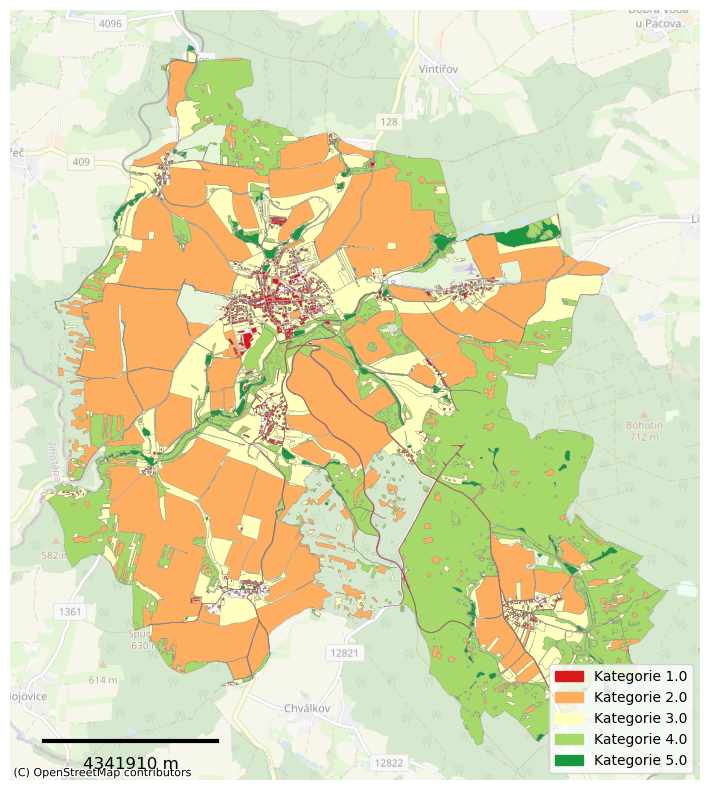

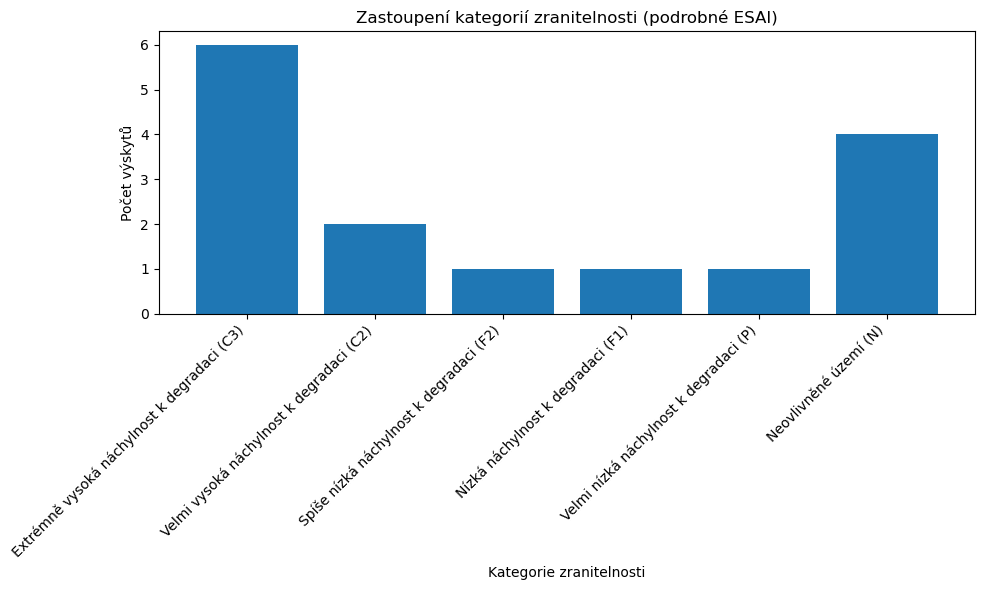

In [ ]:
from datetime import datetime
import uuid
import psycopg2
from rich import print
import matplotlib.pyplot as plt
import io
import base64
import geopandas as gpd
import json
from shapely.geometry import shape
import matplotlib.patches as mpatches
import contextily as ctx


rozsahy_kategorii = {
    "N": (1.00, 1.17, "Neovlivněné území", "#1a9850"),
    "P": (1.17, 1.22, "Velmi nízká náchylnost k degradaci", "#66bd63"),
    "F1": (1.22, 1.26, "Nízká náchylnost k degradaci", "#a6d96a"),
    "F2": (1.26, 1.32, "Spíše nízká náchylnost k degradaci", "#d9ef8b"),
    "F3": (1.32, 1.37, "Střední náchylnost k degradaci", "#fee08b"),
    "C1": (1.37, 1.41, "Vysoká náchylnost k degradaci", "#fdae61"),
    "C2": (1.41, 1.53, "Velmi vysoká náchylnost k degradaci", "#f46d43"),
    "C3": (1.53, 2.00, "Extrémně vysoká náchylnost k degradaci", "#d73027"),
    "N/A": (None, None, "N/A", "#000000")  # Pro 0 vody
}

def urci_kategorii(vazeny_prumer):
    if vazeny_prumer is None:
        return "N/A", "N/A"

    for kod, (minimum, maximum, nazev, _) in rozsahy_kategorii.items():
        if minimum is not None and maximum is not None:
            if minimum <= vazeny_prumer <= maximum:
                return f"{nazev} ({kod})", kod
        elif kod == "N/A" and vazeny_prumer is None:
            return "N/A", "N/A"

    return "Neznámá kategorie", None

def urci_barvu_klasicke_meritko(meritko):
    meritko_cislo = int(meritko.replace("1:", "").replace(" ", ""))
    if meritko_cislo <= 10000:
        return "#006400", ""
    elif meritko_cislo <= 50000:
        return "#FFA500", "Měřítko má méně přesné rozlišení."
    else:
        return "#FF0000", "Měřítko velmi hrubé - Data je potřeba interpretovat obezřetně."

def urci_barvu_meritko_na_pixel(meritko):
    meritko_cislo = int(meritko.replace("m/px", "").replace(" ", ""))
    if meritko_cislo <= 20:
        return "#006400", ""
    elif meritko_cislo <= 100:
        return "#FFA500", "Měřítko má méně přesné rozlišení."
    else:
        return "#FF0000", "Měřítko velmi hrubé - Data je potřeba interpretovat obezřetně."

def urci_barvu_rok(rok):
    aktualni_rok = datetime.now().year
    rozdil = aktualni_rok - rok
    if rozdil < 3:
        return "#1a9641"
    elif rozdil < 5:
        return "#fdae61"
    else:
        return "#d7191c"

dbname = 'DP_pokus'
user = 'postgres'
password = 'kapli4ky'
host = 'localhost'
port = '5432'

try:
    connection = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
    cursor = connection.cursor()
    print("Připojení k databázi bylo úspěšné")

    sql_query_verohodnost_esai = "SELECT zkratka_txt, datovy_zdroj, indikator_cz, meritko, last_update, source_dat FROM metadata_dat"
    sql_query_funkce = "SELECT AVG(hb_n) AS hodnota_hb, AVG(ctot_n) AS hodnota_uhlik, AVG(evap_n) AS hodnota_evapotranspirace FROM cernovice_esai_na_ctverec;"
    sql_query_esai_hlavni = """
        SELECT AVG(w_veget) AS "Stav vegetace", AVG(w_clim) AS "Stav klimatu", AVG(w_soil) AS "Stav půdy", AVG(w_mgm) AS "Intenzita lidské činnosti" FROM cernovice_esai_na_ctverec;
        """

    sql_query_esai_podrobne = """
        SELECT AVG(dra_w) AS "Propustnost", AVG(par_w) AS "Matečná hornina", AVG(dep_w) AS "Hloubka půdy", AVG(fra_w) AS "Skeletovitost", AVG(tex_w) AS "Textura", AVG(slo_w) AS "Sklonitost svahu", AVG(den_w) AS "Hustota populace", AVG(grw_w) AS "Populační růst", AVG(int_w) AS "Intenzita využití půdy", AVG(w_rai) AS "Průměrný roční úhrn srážek", AVG(arid_w) AS "Index sucha", AVG(asp_w) AS "Orientace svahu", AVG(dry_w) AS "Odolnost vegetace vůči suchu", AVG(ero_w) AS "Schopnost vegetace bránit erozi", AVG(pla_w) AS "Pokryvnost vegetace" FROM cernovice_esai_na_ctverec;
        """

    sql_query_esai = """
        SELECT AVG(w_esai) AS "Zranitelnost krajiny" FROM cernovice_esai_na_ctverec;
        """
    sql_query_evap_map = """
        SELECT ST_AsGeoJSON(ST_Transform(geom, 4326)) as geojson_str, evap_k FROM evapotranspirace WHERE ST_IsValid(geom);
    """
    cursor.execute(sql_query_evap_map)
    data_evap_map = cursor.fetchall()
    cursor.execute(sql_query_verohodnost_esai)
    data_verohodnost_esai = cursor.fetchall()

    cursor.execute(sql_query_funkce)
    data_funkce = cursor.fetchall()[0] if cursor.rowcount > 0 else None

    cursor.execute(sql_query_esai)
    data_esai = cursor.fetchall()[0][0] if cursor.rowcount > 0 else None

    cursor.execute(sql_query_esai_hlavni)
    data_esai_hlavni = cursor.fetchall()[0] if cursor.rowcount > 0 else None

    cursor.execute(sql_query_esai_podrobne)
    data_esai_podrobne = cursor.fetchall()[0] if cursor.rowcount > 0 else None

    # Funkce pro získání barvy podle kategorie (PŘESUNUTO NAHORU)
    def get_color_for_category(category):
        if category == 1:
            return '#d7191c'
        elif category == 2:
            return '#fdae61'
        elif category == 3:
            return '#ffffbf'
        elif category == 4:
            return '#a6d96a'
        elif category == 5:
            return '#1a9641'
        else:
            return 'gray'  # Pro neznámé kategorie

    # Převod dat na GeoDataFrame
    geometries = []
    colors = []
    categories = [] # Přidáno pro legendu
    for geojson_str, evap_k in data_evap_map:
        try:
            geojson_data = json.loads(geojson_str)
            geom = shape(geojson_data)
            geometries.append(geom)
            color = get_color_for_category(evap_k)
            colors.append(color)
            categories.append(evap_k) # Přidáno pro legendu
        except Exception as e:
            print(f"Chyba při zpracování GeoJSON: {e}")

    gdf = gpd.GeoDataFrame(geometry=geometries, crs="EPSG:4326")  # Nastavení CRS na WGS 84
    gdf = gdf.to_crs(epsg=3857)  # Převod na Web Mercator pro contextily
    gdf['color'] = colors
    gdf['category'] = categories  # Přidáno pro legendu

    # Vytvoření statické mapy pomocí matplotlib
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color=gdf['color'], edgecolor='grey', linewidth=0.2)
    ax.set_axis_off()  # Vypnutí os

     # Přidání kontextové mapy s přesným měřítkem a průhledností
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)  # alpha=0.5 pro průhlednost



        # Přidání legendy
    legend_elements = [mpatches.Patch(color=get_color_for_category(cat), label=f"Kategorie {cat}")
                       for cat in sorted(gdf['category'].unique())]
    ax.legend(handles=legend_elements, loc='lower right')


    # Uložení mapy do paměti jako PNG
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode()
    buf.close()
        
    if data_esai_hlavni is not None and len(data_esai_hlavni) == 4:
        hlavni_esai_kategorie = sorted(
            [("Stav vegetace", data_esai_hlavni[0]), ("Stav klimatu", data_esai_hlavni[1]), ("Stav půdy", data_esai_hlavni[2]), ("Intenzita lidské činnosti", data_esai_hlavni[3])],
            key=lambda x: x[1], reverse=True
        )
    else:
        print("Chyba: data_esai_hlavni jsou neplatná.")
        hlavni_esai_kategorie = [] # prázdný seznam pro vygenerování tabulky

    podrobne_esai = sorted(
    [("Propustnost", data_esai_podrobne[0]), ("Matečná hornina", data_esai_podrobne[1]), ("Hloubka půdy", data_esai_podrobne[2]), ("Skeletovitost", data_esai_podrobne[3]), ("Textura", data_esai_podrobne[4]), ("Sklonitost svahu", data_esai_podrobne[5]), ("Hustota populace", data_esai_podrobne[6]), ("Populační růst", data_esai_podrobne[7]), ("Intenzita využití půdy", data_esai_podrobne[8]), ("Průměrný roční úhrn srážek", data_esai_podrobne[9]), ("Index sucha", data_esai_podrobne[10]), ("Orientace svahu", data_esai_podrobne[11]), ("Odolnost vegetace vůči suchu", data_esai_podrobne[12]), ("Schopnost vegetace bránit erozi", data_esai_podrobne[13]), ("Pokryvnost vegetace", data_esai_podrobne[14])],
    key=lambda x: x[1], reverse=True
    )
    if data_funkce:
        hodnota_hb, hodnota_uhlik, hodnota_evapotranspirace = data_funkce
    else:
        hodnota_uhlik = "---"
        hodnota_evapotranspirace = "---"
        hodnota_hb = "---"

    def generuj_tabulku_hlavni_kategorie(hlavni_esai_kategorie, urci_kategorii, rozsahy_kategorii):
        tabulka_html = "<table><tr><th>Téma</th><th>Hodnota</th><th>Kategorie</th></tr>"
        for tema, hodnota in hlavni_esai_kategorie:
            kategorie, kod_kategorie = urci_kategorii(hodnota)
            barva_textu = rozsahy_kategorii[kod_kategorie][3] if kod_kategorie in rozsahy_kategorii else "#000000"
            tabulka_html += f"<tr><td><strong>{tema}</strong></td><td>{hodnota}</td><td style='color: {barva_textu};'>{kategorie}</td></tr>"
        tabulka_html += "</table>"
        return tabulka_html

    def generuj_tabulku_podrobna_temata(podrobne_esai, urci_kategorii, rozsahy_kategorii):
        tabulka_html = "<table><tr><th>Téma</th><th>Hodnota</th><th>Kategorie</th></tr>"
        for tema, hodnota in podrobne_esai:
            kategorie, kod_kategorie = urci_kategorii(hodnota)
            barva_textu = rozsahy_kategorii[kod_kategorie][3] if kod_kategorie in rozsahy_kategorii else "#000000"
            tabulka_html += f"<tr><td>{tema}</td><td>{hodnota}</td><td style='color: {barva_textu};'>{kategorie}</td></tr>"
        tabulka_html += "</table>"
        return tabulka_html

    tabulka_hlavni = generuj_tabulku_hlavni_kategorie(hlavni_esai_kategorie, urci_kategorii, rozsahy_kategorii)
    tabulka_podrobna = generuj_tabulku_podrobna_temata(podrobne_esai, urci_kategorii, rozsahy_kategorii)

    timestamp = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
    id = uuid.uuid1()

    kategorie_esai, kod_kategorie_esai = urci_kategorii(data_esai)

    # Sbírání dat pro graf (pouze z podrobne_esai)
    kategorie_counts = {}
    for tema, hodnota in podrobne_esai:
        kategorie, _ = urci_kategorii(hodnota)
        kategorie_counts[kategorie] = kategorie_counts.get(kategorie, 0) + 1

    # Sbírání dat pro graf (pouze z podrobne_esai)
    kategorie_counts = {}
    for tema, hodnota in podrobne_esai:
        kategorie, _ = urci_kategorii(hodnota)
        kategorie_counts[kategorie] = kategorie_counts.get(kategorie, 0) + 1

    # Generování grafu
    kategorie_names = list(kategorie_counts.keys())
    counts = list(kategorie_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(kategorie_names, counts)
    plt.xlabel("Kategorie zranitelnosti")
    plt.ylabel("Počet výskytů")
    plt.title("Zastoupení kategorií zranitelnosti (podrobné ESAI)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Uložení grafu do paměti
    buf = io.BytesIO()
    plt.savefig(buf, format="png")  # Uloží graf jako PNG do paměti
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode()  # Zakóduje graf do base64
    buf.close()

    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Zranitelnost krajiny</title>
        <meta charset='UTF-8'>
        <meta name='description' content='HTML stránka georeportu zranitelnosti krajiny'>
        <meta name='keywords' content='zranitelnost krajiny, georeport, ekologie'>
        <meta name='author' content='Adéla Petřeková'>
        <style>
            @page {{
                size: A4;
                margin: 10mm 20mm;
                @bottom-center {{
                    content: "Strana " counter(page);
                    font-family: Arial, sans-serif;
                    text-align: center;
                }}
            }}
            body {{
                font-family: Arial, sans-serif;
                margin: 0;
                padding: 0;
            }}
            h1 {{
                background-color: #4CAF50;
                color: #fff;
                padding: 10px;
            }}
            p {{
                padding: 10px;
            }}
            .footer {{
                position: fixed;
                bottom: 0;
                width: 100%;
                text-align: center;
            }}
            .footer hr {{
                width: 100%;
                border: none;
                border-top: 1px solid #000;
                margin: 0;
            }}
            .footer-content {{
                display: flex;
                justify-content: space-between;
                align-items: center;
                padding: 0 0;
            }}
            .footer img {{
                height: 50px;
            }}
            .page_number {{
                font-family: Arial, sans-serif;
            }}
            .indicator-box {{
                border: 2px solid #4CAF50;
                padding: 10px;
                margin: 10px 0;
            }}
            table {{
                width: 100%;
                border-collapse: collapse;
            }}
            th, td {{
                border: 1px solid #000;
                padding: 8px;
                text-align: left;
            }}
            th {{
                background-color: #f2f2f2;
            }}
            .graf-container {{
                max-width: 100%;
                overflow-x: auto; /* Přidá horizontální posuvník, pokud je graf příliš široký */
            }}
            .graf-container img {{
                max-width: 100%;
                height: auto;
            }}
        </style>
    </head>
    <body>
        <header>
            <h1>Název reportu: Zranitelnost krajiny</h1>
            <p>Lokalita: GPS (, ) <br>
            Souřadnice: MBR extentu  <br>
            Datum a čas generování: {timestamp} <br>
            Unikatní identifikátor: {id}
            </p>
        </header>
        <main>
            <p> Tento report podává zprávu o degradaci krajiny na základě metody ESAI ....</p>

            <h2> Krok I: Náchylnost krajiny k degradaci </h2>
            <p> Ve zvoleném území dosahuje výsledná hodnota náchylnosti k degradaci hodnoty <strong>{data_esai}</strong> a je klasifikována jako <span style="color: {rozsahy_kategorii[kod_kategorie_esai][3]};">{kategorie_esai}</span>.</p>
            {tabulka_hlavni}

            <h3> Podřazená témata </h3>
            {tabulka_podrobna}

    """

    serazene_podrobne_esai = sorted(podrobne_esai, key=lambda x: x[1], reverse=True)
    nejhorsi_indikatory = [f"<em>{tema}</em>" for tema, _ in serazene_podrobne_esai[:3]]
    html += "<div class='indicator-box'> Nejhorší 3 indikátory v zájmovém území jsou: " + ", ".join(nejhorsi_indikatory) + ".</div>"

    html += f"""
            <div class="graf-container">
            <h4>Graf: Zastoupení kategorií zranitelnosti (podrobné ESAI)</h4>
            <img src="data:image/png;base64,{image_base64}" alt="Graf zastoupení kategorií (podrobné ESAI)">
            </div>
            <h3> Věrohodnost dat </h3>
            <table>
                <tr>
                    <th> Zkratka </th>
                    <th> Název </th>
                    <th> Datový zdroj </th>
                    <th> Garant </th>
                    <th> Měřítko </th>
                    <th> Rok aktualizace </th>
                </tr>
    """

    for zkratka_txt, datovy_zdroj, indikator_cz, meritko, last_update, source_dat in data_verohodnost_esai:
        if "1:" in meritko:
            barva, poznamka = urci_barvu_klasicke_meritko(meritko)
        elif "m/px" in meritko:
            barva, poznamka = urci_barvu_meritko_na_pixel(meritko)
        barva_rok = urci_barvu_rok(last_update)

        html += f"""
                <tr>
                    <td> {zkratka_txt} </td>
                    <td> {indikator_cz} </td>
                    <td> {datovy_zdroj} </td>
                    <td> {source_dat} </td>
                    <td style="color: {barva};"> {meritko} {poznamka} </td>
                    <td style="color: {barva_rok};"> {last_update} </td>
                </tr>
        """

    html += f"""
            </table>
            <h2> Krok II: Posouzení funkčnosti krajiny </h2>
            <p> slouží k nalezení krajinných segmentů jejichž degradace bude mít velký/malý význam dopad na funkčnost krajiny </p>
            <table>
                <tr>
                    <th> </th>
                    <th> Hodnota </th>
                    <th> Kategorie </th>
                </tr>
                <tr>
                    <td> Zásoba uhlíku ve vegetaci </td>
                    <td> {hodnota_uhlik} </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Evapotranspirace </td>
                    <td> {hodnota_evapotranspirace} </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Ekologická hodnota biotopu </td>
                    <td> {hodnota_hb} </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Vodoretence </td>
                    <td> Hodnota 1 </td>
                    <td> Kategorie 1 </td>
                </tr>
                <tr>
                    <td> Integrovaná hodnota </td>
                    <td> --- </td>
                    <td> Kategorie 1 </td>
                </tr>
            </table>
    """
    # Vložení mapy do HTML reportu
    html += f"""
    <h2>Mapa evapotranspirace</h2>
    <img src="data:image/png;base64,{img_base64}" width="800" height="600" alt="Mapa evapotranspirace">
    """ 

    html += f"""
        <h3> Věrohodnost dat </h3>
                <table>
                    <tr>
                        <th> Název </th>
                        <th> Datový zdroj geometrie/KB </th>
                        <th> Garant </th>
                        <th> Měřítko </th>
                        <th> Rok aktualizace </th>
                    </tr>
                    <tr>
                        <td> Indikátor 1 </td>
                        <td> Hodnota 1 </td>
                        <td> Věrohodnost 1 </td>
                        <td> meritko </td>
                        <td> ROK </td>
                    </tr>
                </table>
                <h2> Krok III: Odolnost krajiny </h2>
                <h2> Krok IV: Syntéza/lokalizace prioritních opatření </h2>
                <h2> Krok V: Typizace prioritních opatření </h2>
            </main>
            <footer>
                <div class="footer">
                    <hr>
                    <div class="footer-content">
                        <img src="katedra_logo.png" alt="Logo KGI">
                        <img src="logo_czechglobe.png" alt="Logo CzechGlobe">
                    </div>
                </div>
            </footer>
        </body>
        </html>
    """

    

    print("HTML report byl úspěšně vygenerován.")

except Exception as error:
    print(f"Chyba při zpracování databáze nebo generování mapy: {error}")

finally:
    if connection:
        cursor.close()
        connection.close()


In [71]:
# Vytvoření HTML souboru
with open("index.html", "w", encoding="utf-8") as f:
    f.write(f"""{html}""")

print("HTML report byl úspěšně vygenerován.")


HTML report byl úspěšně vygenerován.

In [72]:
# output html as a PDF
# first, import the necessary modules

from weasyprint import HTML
# then, convert the HTML to a PDF
HTML("index.html").write_pdf("index.pdf")

print("Generated index.pdf")
#otevření pdf souboru
import webbrowser
webbrowser.open("index.pdf")

Generated index.pdf

True